# Import everything needed for MORO

In [1]:
SEED = 42 
import numpy.random
import random
numpy.random.seed(SEED)
random.seed(SEED)
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import functools

In [2]:
from ema_workbench import (Model, RealParameter, Policy, Constant, Scenario, Constraint, 
                           ScalarOutcome, MultiprocessingEvaluator, ema_logging, perform_experiments)
from ema_workbench.util import ema_logging, save_results, load_results
from ema_workbench.em_framework.optimization import (EpsilonProgress, HyperVolume, ArchiveLogger)
from problem_formulation import get_model_for_problem_formulation
from ema_workbench.em_framework import sample_uncertainties
from ema_workbench.em_framework.evaluators import BaseEvaluator

%matplotlib inline  
# With this backend, the output of plotting commands is displayed inline within frontends like the Jupyter notebook, 
# directly below the code cell that produced it. The resulting plots will then also be stored in the notebook document.

ema_logging.log_to_stderr(ema_logging.INFO)
dike_model, planning_steps = get_model_for_problem_formulation(1) # assign problem_formulation_id


C:\Users\georg\Anaconda3\lib\importlib\_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


## Run this if you want to have policies only at step 1

In [27]:
# dike_model.constants = [Constant('0_RfR 1',0)]
# dike_model.constants = [Constant('0_RfR 2',0)]
# dike_model.constants = [Constant('1_RfR 1',0)]
# dike_model.constants = [Constant('1_RfR 2',0)]
# dike_model.constants = [Constant('2_RfR 1',0)]
# dike_model.constants = [Constant('2_RfR 2',0)]
# dike_model.constants = [Constant('3_RfR 1',0)]
# dike_model.constants = [Constant('3_RfR 2',0)]
# dike_model.constants = [Constant('4_RfR 1',0)]
# dike_model.constants = [Constant('4_RfR 2',0)]

# dike_model.constants = [Constant('A.1_DikeIncrease 1',0)]
# dike_model.constants = [Constant('A.1_DikeIncrease 2',0)]
# dike_model.constants = [Constant('A.2_DikeIncrease 1',0)]
# dike_model.constants = [Constant('A.2_DikeIncrease 2',0)]
# dike_model.constants = [Constant('A.3_DikeIncrease 1',0)]
# dike_model.constants = [Constant('A.3_DikeIncrease 2',0)]
# dike_model.constants = [Constant('A.4_DikeIncrease 1',0)]
# dike_model.constants = [Constant('A.4_DikeIncrease 2',0)]
# dike_model.constants = [Constant('A.5_DikeIncrease 1',0)]
# dike_model.constants = [Constant('A.5_DikeIncrease 2',0)]

In [14]:
'''
For different list of outcomes:
# 0 = 2-objective PF
# 1 = 3-objective PF
# 2 = 5-objective PF
# 3 = Disaggregate over locations
# 4 = Disaggregate over time
# 5 = Fully disaggregated
'''

'\nFor different list of outcomes:\n# 0 = 2-objective PF\n# 1 = 3-objective PF\n# 2 = 5-objective PF\n# 3 = Disaggregate over locations\n# 4 = Disaggregate over time\n# 5 = Fully disaggregated\n'

In [3]:
for levers in dike_model.levers:
    print(levers)

0_RfR 0
1_RfR 0
2_RfR 0
3_RfR 0
4_RfR 0
EWS_DaysToThreat
A.1_DikeIncrease 0
A.2_DikeIncrease 0
A.3_DikeIncrease 0
A.4_DikeIncrease 0
A.5_DikeIncrease 0


# Define the robustness metrics

In [4]:

# percentile90 = functools.partial(np.percentile, q=90)
# def var_mean(data):
#     return ((np.percentile(data,q=75)-np.percentile(data,q=25))*np.sum(data)/(data.shape[0]))

def mean_rob(data):
    return np.sum(data)/(data.shape[0]*1e9)

def threshold(direction, threshold, data):
    if direction == SMALLER:
        return np.sum(data<=threshold)/data.shape[0]
    else:
        return np.sum(data>=threshold)/data.shape[0]

MAXIMIZE = ScalarOutcome.MAXIMIZE
MINIMIZE = ScalarOutcome.MINIMIZE 

SMALLER = "SMALLER"

death_funcs = functools.partial(threshold, SMALLER, 0.00001)
damage_funcs = functools.partial(threshold, SMALLER, 100000)

robustness_functions = [ScalarOutcome('Robustness metric Deaths', kind=MAXIMIZE,
                             variable_name='Expected Number of Deaths', function = death_funcs),
                        ScalarOutcome('Robustness metric Damage', kind=MAXIMIZE,
                             variable_name='Expected Annual Damage', function = damage_funcs),
                        ScalarOutcome('Robustness metric Costs', kind=MINIMIZE,
                             variable_name='Total Investment Costs', function = mean_rob)]

In [10]:
# Expected Annual Damage
# RfR Investment Costs
# Evacuation Costs
# Expected Number of Deaths
# Total Investment Costs
scen = 150
pol = 12

# Check the number of needed scenarios

In [11]:
%%time 
from ema_workbench import ema_logging, MultiprocessingEvaluator

ema_logging.log_to_stderr(ema_logging.INFO)

with MultiprocessingEvaluator(dike_model) as evaluator:
    results = evaluator.perform_experiments(scenarios=scen,               
                                            policies=pol)


[MainProcess/INFO] pool started
[MainProcess/INFO] performing 150 scenarios * 12 policies * 1 model(s) = 1800 experiments
[MainProcess/INFO] 180 cases completed
[MainProcess/INFO] 360 cases completed
[MainProcess/INFO] 540 cases completed
[MainProcess/INFO] 720 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1080 cases completed
[MainProcess/INFO] 1260 cases completed
[MainProcess/INFO] 1440 cases completed
[MainProcess/INFO] 1620 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


Wall time: 20min 12s


In [12]:
save_results(results, f"Outputs/perform_experiments/scen{scen}pol{pol}.tar.gz")

[MainProcess/INFO] results saved successfully to C:\Users\georg\OneDrive\Documents\GitHub\MBDM-group-11\final assignment\Outputs\perform_experiments\scen150pol12.tar.gz


In [6]:
### other experiments perform_experiments400scen6pol.tar.gz
results = load_results(f"Outputs/perform_experiments/scen{scen}pol{pol}.tar.gz")
experiments, outcomes = results

[MainProcess/INFO] results loaded succesfully from C:\Users\georg\OneDrive\Documents\GitHub\MBDM-group-11\final assignment\Outputs\perform_experiments\scen150pol12.tar.gz


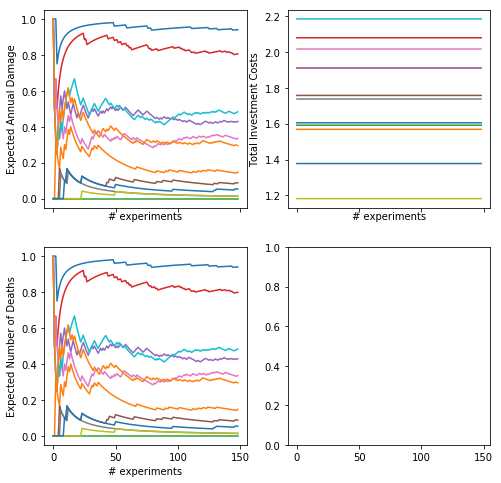

In [7]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(8,8),
                        sharex=True)
axes = [axes[0,0],axes[0,1],axes[1,0],axes[1,1]]                             #axes[1,1]

SMALLER = 'SMALLER'
robustness_funcs = {"Expected Number of Deaths": functools.partial(threshold, SMALLER, 0.00001),
                    "Expected Annual Damage": functools.partial(threshold, SMALLER, 100000), 
                    "Total Investment Costs": mean_rob }


for ax, (outcome, value) in zip(axes, outcomes.items()):
    for policy in np.unique(experiments['policy']):
        logical = experiments['policy'] == policy
        data = value[logical]
        
        robustness = []
      
        for i in range(1, data.shape[0]):
            robustness.append(robustness_funcs[outcome](data[0:i]))
        ax.plot(robustness, label=policy)
    ax.set_xlabel("# experiments")
    ax.set_ylabel(outcome)

In [65]:
# decision_varnames = list(dike_model.levers.keys())
# outcome_varnames = ["frac_{}".format(var_name) for var_name in dike_model.outcomes.keys()]
# outcome_varnames

In [5]:
n_scenarios = 2
nfe = 10000
scenarios = sample_uncertainties(dike_model, n_scenarios)
epsilons = [0.0005, 0.0005, 0.001]

In [6]:
%%time
BaseEvaluator.reporting_frequency = 15

convergence_metrics = [HyperVolume(minimum=[0,0,0], maximum=[1.1, 3, 1.1]),
                       EpsilonProgress()]
 
    
# constraint = [Constraint("Death constraint", outcome_names="Expected Number of Deaths", function=lambda x:max(0, 0.75-x))]

with MultiprocessingEvaluator(dike_model) as evaluator:
    archive, convergence = evaluator.robust_optimize(robustness_functions, scenarios,
                            nfe=nfe, convergence=convergence_metrics, epsilons=epsilons, logging_freq = 1, convergence_freq = 10)

archive.to_csv(f"Outputs/robust_optimization/Archive{n_scenarios}scen{nfe}nfe{epsilons}")
convergence.to_csv(f"Outputs/robust_optimization/Convergence{n_scenarios}scen{nfe}nfe{epsilons}")

[MainProcess/INFO] pool started
[MainProcess/INFO] generation 0: 0/10000 nfe
[MainProcess/INFO] generation 1: 100/10000 nfe
[MainProcess/INFO] generation 2: 199/10000 nfe
[MainProcess/INFO] generation 3: 299/10000 nfe
[MainProcess/INFO] generation 4: 399/10000 nfe
[MainProcess/INFO] generation 5: 496/10000 nfe
[MainProcess/INFO] generation 6: 594/10000 nfe
[MainProcess/INFO] generation 7: 694/10000 nfe
[MainProcess/INFO] generation 8: 792/10000 nfe
[MainProcess/INFO] generation 9: 892/10000 nfe
[MainProcess/INFO] generation 10: 991/10000 nfe
[MainProcess/INFO] generation 11: 1090/10000 nfe
[MainProcess/INFO] generation 12: 1188/10000 nfe
[MainProcess/INFO] generation 13: 1287/10000 nfe
[MainProcess/INFO] generation 14: 1387/10000 nfe
[MainProcess/INFO] generation 15: 1486/10000 nfe
[MainProcess/INFO] generation 16: 1585/10000 nfe
[MainProcess/INFO] generation 17: 1680/10000 nfe
[MainProcess/INFO] generation 18: 1779/10000 nfe
[MainProcess/INFO] generation 19: 1876/10000 nfe
[MainProces

Wall time: 45min 36s


In [23]:
archive = pd.read_csv(f"Outputs/robust_optimization/Archive{n_scenarios}scen{nfe}nfe{epsilons}", index_col=0)
convergence = pd.read_csv(f"Outputs/robust_optimization/Convergence{n_scenarios}scen{nfe}nfe{epsilons}", index_col=0)

In [7]:
print(archive)

   0_RfR 0  1_RfR 0  2_RfR 0  3_RfR 0  4_RfR 0  EWS_DaysToThreat  \
0        0        0        0        0        0                 3   
1        0        0        0        0        0                 2   
2        0        0        0        0        0                 2   

   A.1_DikeIncrease 0  A.2_DikeIncrease 0  A.3_DikeIncrease 0  \
0                   3                   5                   5   
1                   0                   0                   5   
2                   1                   3                   4   

   A.4_DikeIncrease 0  A.5_DikeIncrease 0  Robustness metric Deaths  \
0                   4                   5                       1.0   
1                   4                   0                       0.0   
2                   2                   5                       0.5   

   Robustness metric Damage  Robustness metric Costs  
0                       1.0                 0.176872  
1                       0.0                 0.038498  
2               

In [9]:
convergence

,hypervolume,epsilon_progress,nfe
0,0.000000,0,0
1,0.238641,9,100
2,0.240196,10,199
3,0.243421,12,299
4,0.244978,13,399
5,0.247154,14,496
6,0.252431,16,594
7,0.254173,19,694
8,0.254856,20,792
9,0.254988,22,892


In [8]:
# check the found solutions
levers = archive.loc[:, [l.name for l in dike_model.levers]]
levers.T

,0,1,2
0_RfR 0,0,0,0
1_RfR 0,0,0,0
2_RfR 0,0,0,0
3_RfR 0,0,0,0
4_RfR 0,0,0,0
EWS_DaysToThreat,3,2,2
A.1_DikeIncrease 0,3,0,1
A.2_DikeIncrease 0,5,0,3
A.3_DikeIncrease 0,5,5,4
A.4_DikeIncrease 0,4,4,2


In [33]:
policies_to_evaluate = [Policy('policy'+str(i), **policy.to_dict()) 
                        for i, policy in pd.DataFrame.from_dict(levers).iterrows()]
# policies_to_evaluate

## Convergence of ε and hypervolume

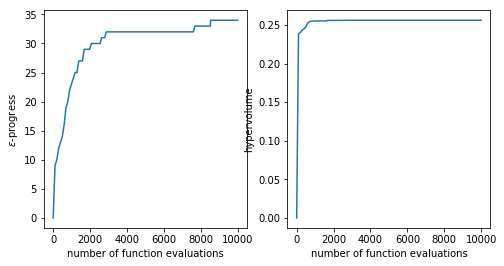

In [10]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=True, figsize=(8,4))
ax1.plot(convergence.nfe, convergence.epsilon_progress)
ax1.set_ylabel('$\epsilon$-progress')
ax2.plot(convergence.nfe, convergence.hypervolume)
ax2.set_ylabel('hypervolume')

ax1.set_xlabel('number of function evaluations')
ax2.set_xlabel('number of function evaluations')
plt.show()